In [489]:
import sys
sys.path.append('/home/ubuntu/workbench/MTLMusicRepresentation/')
from model.model import Model
import namedtupled
from sklearn.externals import joblib

from lasagne import layers as L
from collections import OrderedDict

state = joblib.load('/mnt/bulk2/exp_res/models/1/conv_2d_tag_pref_50_intersc_bfc_run1_state.dat.gz')
state_nt = namedtupled.map(state)
model = Model(state_nt.config)

(None, 2, 216, 128)
(None, 2, 216, 128)
('conv1.pl', (None, 16, 54, 64))
('conv2.pl', (None, 32, 27, 32))
('conv3.pl', (None, 64, 13, 16))
('conv4.pl', (None, 64, 6, 8))
('conv5.pl', (None, 128, 3, 4))
('conv6.2.bn.nonlin', (None, 256, 3, 4))
(None, 50)
(None, 50)
Loadong pre-trained weight...


In [490]:
ARCH_TEMPLATE = [
    # input block
    'input', 'noise', 'sclr',
    # conv-pool block
    'conv1.1', 'conv1.1.bn', 'conv1.1.bn.nonlin', 'conv1.pl',
    'conv2.1', 'conv2.1.bn', 'conv2.1.bn.nonlin', 'conv2.pl',
    'conv3.1', 'conv3.1.bn', 'conv3.1.bn.nonlin', 'conv3.pl',
    'conv4.1', 'conv4.1.bn', 'conv4.1.bn.nonlin', 'conv4.pl',
    'conv5.1', 'conv5.1.bn', 'conv5.1.bn.nonlin', 'conv5.pl',
    'conv6.1', 'conv6.1.bn', 'conv6.1.bn.nonlin',
    'conv6.2', 'conv6.2.bn', 'conv6.2.bn.nonlin',
    'gap_bn',
    # output block
    'fc', 'fc_bn', 'fc_bn_nonlin', 'fc_dropout',
    'out'
]
branch_at = model.config.hyper_parameters.branch_at
targets = model.config.target

In [491]:
from functools import partial

# define condition function
def find_layer(l, kw):
    if l.name is not None:
        return kw in l.name
    else:
        return False

def fetch_parameters(layers, cur_layer, n_lrn_src, verbose=True):
    """
    """
    # resulting containor
    param_res = {}    

    # fetch saved layers
    condition = partial(find_layer, kw=cur_layer)
    with_layer_n = filter(condition, layers)
    if 'bn' not in cur_layer:
        with_layer_n = filter(lambda l: 'bn' not in l.name, with_layer_n)
        
    # filter layers without weights
    with_layer_n = filter(lambda l: len(l.params) > 0, with_layer_n)
    if len(with_layer_n) == 1:
        n_lrn_src = 1
    if len(with_layer_n) > 0:
        # merge weight
        if 'bn' not in cur_layer:
            if 'conv' in cur_layer:  # Conv2D
                if str(branch_at) + '.1' in cur_layer:  # do the out dim merge
                    W = np.concatenate(map(lambda l: l.W.get_value(), with_layer_n), axis=0)
                else:  # do the full merge (diagonal tensor)
                    o_, i_, w_, h_ = with_layer_n[0].W.get_value().shape
                    W = np.zeros([o_ * n_lrn_src, i_ * n_lrn_src, w_, h_])
                    for i, l in enumerate(with_layer_n):
                        W[i * o_: (i+1) * o_, i * i_: (i+1) * i_] = l.W.get_value()
                b = np.concatenate(map(lambda l: l.b.get_value(), with_layer_n))
                
            else:  # FC
                if branch_at == 'fc':  # do the out dim merge
                    W = np.concatenate(map(lambda l: l.W.get_value(), with_layer_n), axis=1)
                else:
                    i_, o_ = with_layer_n[0].W.get_value().shape
                    W = np.zeros([i_ * n_lrn_src, o_ * n_lrn_src])
                    for i, l in enumerate(with_layer_n):
                        W[i * i_: (i+1) * i_, i * o_: (i+1) * o_] = l.W.get_value()
                if with_layer_n[0].b is not None:
                    o_, = with_layer_n[0].b.get_value().shape
                    b = np.zeros([o_ * n_lrn_src, ])
                    for i, l in enumerate(with_layer_n):
                        b[i * o_: (i+1) * o_] = l.b.get_value()
                else:
                    b = None
            
            if verbose:
                print layer, W.shape, b.shape if b is not None else None
            param_res['W'] = W
            param_res['b'] = b
                
        elif 'bn' in cur_layer:
            gamma = np.concatenate(map(lambda l: l.gamma.get_value(), with_layer_n))
            beta = np.concatenate(map(lambda l: l.beta.get_value(), with_layer_n))
            mean = np.concatenate(map(lambda l: l.mean.get_value(), with_layer_n))
            inv_std = np.concatenate(map(lambda l: l.inv_std.get_value(), with_layer_n))
            
            if verbose:
                print layer, gamma.shape, beta.shape, mean.shape, inv_std.shape
            param_res['gamma'] = gamma
            param_res['beta'] = beta
            param_res['mean'] = mean
            param_res['inv_std'] = inv_std
        else:
            print with_layer_n
        
        return param_res
    
    
# get all layers
all_layers = L.get_all_layers(model.net.values())

# set some variables...
lrn_src = model.config.target
n_lrn_src = len(lrn_src)

# start process
weights = OrderedDict()
shared = True

# following layers manually processed (always shared blocks)
weights['sclr'] = {}
weights['sclr']['offset'] = -all_layers[2].b.get_value()
weights['sclr']['scale'] = 1./all_layers[3].params.keys()[0].get_value()
print 'sclr', weights['sclr']['offset'].shape, weights['sclr']['scale'].shape

for layer in ARCH_TEMPLATE:
    if layer in ['input', 'noise', 'sclr']:
        continue
    weight = fetch_parameters(all_layers, layer, n_lrn_src)
    if weight is not None:
        weights[layer] = weight

sclr (128,) (128,)
conv1.1 (16, 2, 5, 5) (16,)
conv1.1.bn (16,) (16,) (16,) (16,)
conv2.1 (32, 16, 3, 3) (32,)
conv2.1.bn (32,) (32,) (32,) (32,)
conv3.1 (64, 32, 3, 3) (64,)
conv3.1.bn (64,) (64,) (64,) (64,)
conv4.1 (64, 64, 3, 3) (64,)
conv4.1.bn (64,) (64,) (64,) (64,)
conv5.1 (128, 64, 3, 3) (128,)
conv5.1.bn (128,) (128,) (128,) (128,)
conv6.1 (256, 128, 3, 3) (256,)
conv6.1.bn (256,) (256,) (256,) (256,)
conv6.2 (256, 256, 1, 1) (256,)
conv6.2.bn (256,) (256,) (256,) (256,)
gap_bn (256,) (256,) (256,) (256,)
fc (256, 256) None
fc_bn (256,) (256,) (256,) (256,)
out (256, 100) (100,)


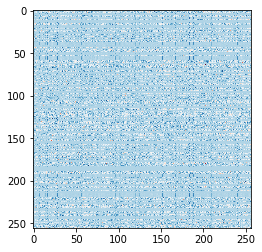

In [492]:
plt.imshow(weights['conv6.2']['W'][:, :, 0, 0], cmap='RdBu')

In [493]:
from lasagne.nonlinearities import rectify, softmax

# make a template arch with dict
template_net = OrderedDict([
    ('input', (L.InputLayer, {'shape': (None, 2, 216, 128)})),
    ('noise', (L.GaussianNoiseLayer, {'sigma': 0.})),
    ('sclr', (L.standardize, {'shared_axes': (0,1,2)})),
    
    ('conv1.1', (L.Conv2DLayer, {'stride': (2,1), 'pad': 'same', 'nonlinearity': None})),
    ('conv1.1.bn', (L.BatchNormLayer, None)),
    ('conv1.1.bn.nonlin', (L.NonlinearityLayer, {'nonlinearity': rectify})),
    ('conv1.1.pl', (L.MaxPool2DLayer, {'pool_size': (2, 2)})),
    
    ('conv2.1', (L.Conv2DLayer, {'pad': 'same', 'nonlinearity': None})),
    ('conv2.1.bn', (L.BatchNormLayer, None)),
    ('conv2.1.bn.nonlin', (L.NonlinearityLayer, {'nonlinearity': rectify})),
    ('conv2.1.pl', (L.MaxPool2DLayer, {'pool_size': (2, 2)})),

    ('conv3.1', (L.Conv2DLayer, {'pad': 'same', 'nonlinearity': None})),
    ('conv3.1.bn', (L.BatchNormLayer, None)),
    ('conv3.1.bn.nonlin', (L.NonlinearityLayer, {'nonlinearity': rectify})),
    ('conv3.1.pl', (L.MaxPool2DLayer, {'pool_size': (2, 2)})),

    ('conv4.1', (L.Conv2DLayer, {'pad': 'same', 'nonlinearity': None})),
    ('conv4.1.bn', (L.BatchNormLayer, None)),
    ('conv4.1.bn.nonlin', (L.NonlinearityLayer, {'nonlinearity': rectify})),
    ('conv4.1.pl', (L.MaxPool2DLayer, {'pool_size': (2, 2)})),

    ('conv5.1', (L.Conv2DLayer, {'pad': 'same', 'nonlinearity': None})),
    ('conv5.1.bn', (L.BatchNormLayer, None)),
    ('conv5.1.bn.nonlin', (L.NonlinearityLayer, {'nonlinearity': rectify})),
    ('conv5.1.pl', (L.MaxPool2DLayer, {'pool_size': (2, 2)})),

    ('conv6.1', (L.Conv2DLayer, {'pad': 'same', 'nonlinearity': None})),
    ('conv6.1.bn', (L.BatchNormLayer, None)),
    ('conv6.1.bn.nonlin', (L.NonlinearityLayer, {'nonlinearity': rectify})),
    ('conv6.2', (L.Conv2DLayer, {'pad': 'same', 'nonlinearity': None})),
    ('conv6.2.bn', (L.BatchNormLayer, None)),
    ('conv6.2.bn.nonlin', (L.NonlinearityLayer, {'nonlinearity': rectify})),
    
    ('gap', (L.GlobalPoolLayer, None)),
    ('gap_bn', (L.BatchNormLayer, None)),
    
    ('fc', (L.DenseLayer, {'nonlinearity': None, 'b': None})),
    ('fc_bn', (L.BatchNormLayer, None)),
    ('fc_bn_nonlin', (L.NonlinearityLayer, {'nonlinearity': rectify})),
    ('fc_dropout', (L.DropoutLayer, None)),
    
    ('out', (L.DenseLayer, {'nonlinearity': softmax}))
])

# fetch the network params with `keys` & update params dict
for k, v in weights.iteritems():
    if template_net[k][1] is not None:
        if template_net[k][0] == L.Conv2DLayer:
            v.update({'num_filters': v['W'].shape[0], 'filter_size': v['W'].shape[2:]})
        if template_net[k][0] == L.DenseLayer:
            v.update({'num_units': v['W'].shape[1]})
        template_net[k][1].update(v)
    else:
        template_net[k] = (template_net[k][0], v)
        

In [500]:
import inspect

is_out = True
# now initialize the layers with given network params
for name, layer_param in template_net.iteritems():
    if not is_out:
        if name == 'out':
            break
#     if name == 'conv1.1':
#         break

    if name == 'input':
        net = layer_param[0](name=name, **layer_param[1])
    else:
        if name != 'sclr':
            if layer_param[1] is not None:
                net = layer_param[0](net, name=name, **layer_param[1])
            else:
                net = layer_param[0](net, name=name)
        else:
            net = layer_param[0](net, **layer_param[1])
        
        print name, net.output_shape

noise (None, 2, 216, 128)
sclr (None, 2, 216, 128)
conv1.1 (None, 16, 108, 128)
conv1.1.bn (None, 16, 108, 128)
conv1.1.bn.nonlin (None, 16, 108, 128)
conv1.1.pl (None, 16, 54, 64)
conv2.1 (None, 32, 54, 64)
conv2.1.bn (None, 32, 54, 64)
conv2.1.bn.nonlin (None, 32, 54, 64)
conv2.1.pl (None, 32, 27, 32)
conv3.1 (None, 64, 27, 32)
conv3.1.bn (None, 64, 27, 32)
conv3.1.bn.nonlin (None, 64, 27, 32)
conv3.1.pl (None, 64, 13, 16)
conv4.1 (None, 64, 13, 16)
conv4.1.bn (None, 64, 13, 16)
conv4.1.bn.nonlin (None, 64, 13, 16)
conv4.1.pl (None, 64, 6, 8)
conv5.1 (None, 128, 6, 8)
conv5.1.bn (None, 128, 6, 8)
conv5.1.bn.nonlin (None, 128, 6, 8)
conv5.1.pl (None, 128, 3, 4)
conv6.1 (None, 256, 3, 4)
conv6.1.bn (None, 256, 3, 4)
conv6.1.bn.nonlin (None, 256, 3, 4)
conv6.2 (None, 256, 3, 4)
conv6.2.bn (None, 256, 3, 4)
conv6.2.bn.nonlin (None, 256, 3, 4)
gap (None, 256)
gap_bn (None, 256)
fc (None, 256)
fc_bn (None, 256)
fc_bn_nonlin (None, 256)
fc_dropout (None, 256)
out (None, 100)


In [504]:
L.get_all_params(net)

[b,
 scales,
 conv1.1.W,
 conv1.1.b,
 conv1.1.bn.beta,
 conv1.1.bn.gamma,
 conv1.1.bn.mean,
 conv1.1.bn.inv_std,
 conv2.1.W,
 conv2.1.b,
 conv2.1.bn.beta,
 conv2.1.bn.gamma,
 conv2.1.bn.mean,
 conv2.1.bn.inv_std,
 conv3.1.W,
 conv3.1.b,
 conv3.1.bn.beta,
 conv3.1.bn.gamma,
 conv3.1.bn.mean,
 conv3.1.bn.inv_std,
 conv4.1.W,
 conv4.1.b,
 conv4.1.bn.beta,
 conv4.1.bn.gamma,
 conv4.1.bn.mean,
 conv4.1.bn.inv_std,
 conv5.1.W,
 conv5.1.b,
 conv5.1.bn.beta,
 conv5.1.bn.gamma,
 conv5.1.bn.mean,
 conv5.1.bn.inv_std,
 conv6.1.W,
 conv6.1.b,
 conv6.1.bn.beta,
 conv6.1.bn.gamma,
 conv6.1.bn.mean,
 conv6.1.bn.inv_std,
 conv6.2.W,
 conv6.2.b,
 conv6.2.bn.beta,
 conv6.2.bn.gamma,
 conv6.2.bn.mean,
 conv6.2.bn.inv_std,
 gap_bn.beta,
 gap_bn.gamma,
 gap_bn.mean,
 gap_bn.inv_std,
 fc.W,
 fc_bn.beta,
 fc_bn.gamma,
 fc_bn.mean,
 fc_bn.inv_std,
 out.W,
 out.b]

# Test

In [495]:
# compile feature function
feature = L.get_output(net, deterministic=True)
layers_rebuild = L.get_all_layers(net)
f_feature = theano.function([layers_rebuild[0].input_var], feature, allow_input_downcast=True)

In [496]:
# test with random input
x = np.random.rand(1, 2, 216, 128)
z_hat = f_feature(x)
if branch_at == 'fc':
    z = model.feature(model.config.target[0], x)
else:
    z = np.concatenate([model.feature(t, x).ravel() for t in model.config.target])

In [497]:
print 'all same?:', np.isclose(z_hat, z).all()
print 'how same?: {:.2f}'.format(np.isclose(z_hat, z).sum() / float(np.prod(z.shape)))

all same?: True
how same?: 1.00


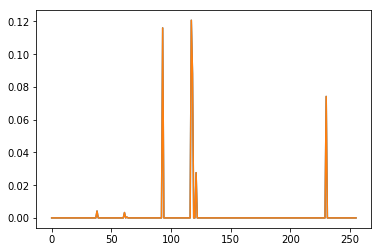

In [498]:
plt.plot(z_hat.ravel())
plt.plot(z.ravel())